#Load, format cleaned data:

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('/Users/fineiskid/Desktop/Healthcare_Prediction/data/frank_clean_data.csv', na_values='na',
                  keep_default_na = True)
data.head(5)

,aa_primarykey,agep,hincp,np,pap,veh,wkhp,hicov,rwat,cit,fs,mar,sex,dis,rac1p,mil,sch,wif,mv,cow
0,1,1.714639,-0.806771,-0.694199,-0.074189,-0.055156,NaN,1,1,4,0,1,1,1,1,3,1,0,6,NaN
1,2,0.860682,0.084138,-0.694199,-0.074189,-0.055156,NaN,NaN,1,1,0,1,0,0,1,5,1,1,3,1
2,3,-0.548348,-0.644095,-0.126756,-0.074189,-0.949111,0.159869,0,1,1,0,5,1,0,1,5,1,0,1,1
3,4,0.817984,-0.381016,-0.694199,-0.074189,-0.055156,0.159869,NaN,1,1,0,1,1,0,1,5,1,1,6,5
4,5,0.860682,-0.360681,-0.694199,-0.074189,-0.055156,NaN,NaN,1,1,0,3,0,0,1,5,1,1,5,3


#Let's separate people with healthcare coverage (training data) from those without (test data), and then grab all of the clean training data (no missing values). Also, make sure Python knows you have categorical data.

#######Note: 
First we need to find the locations of the NA data and then separate, as it's really hard to identify NA values once we make the *hicov* data categorical...

In [2]:
#Separate known health coverage from unknown health coverage
data_known = data.loc[~np.isnan(data.hicov)] #Eventual training data
data_unknown = data.loc[np.isnan(data.hicov)] #Eventual test data

train_data = data_known.dropna(axis = 0)

test_data = data_unknown[data_unknown.columns[data_unknown.columns != 'hicov']].dropna(axis = 0)
test_data['hicov'] = np.nan

In [3]:
#Make categorical data astype('category')
train_data.loc[:,"cit"] = train_data.loc[:,"cit"].astype("category")
train_data.loc[:,"dis"] = train_data.loc[:,"dis"].astype("category")
train_data.loc[:,"fs"] = train_data.loc[:,"fs"].astype("category")
train_data.loc[:,"hicov"] = train_data.loc[:,"hicov"].astype("category")
train_data.loc[:,"mar"] = train_data.loc[:,"mar"].astype("category")
train_data.loc[:,"rac1p"] = train_data.loc[:,"rac1p"].astype("category")
train_data.loc[:,"rwat"] = train_data.loc[:,"rwat"].astype("category")
train_data.loc[:,"mil"] = train_data.loc[:,"mil"].astype("category")
train_data.loc[:,"sex"] = train_data.loc[:,"sex"].astype("category")

test_data.loc[:,"cit"] = test_data.loc[:,"cit"].astype("category")
test_data.loc[:,"dis"] = test_data.loc[:,"dis"].astype("category")
test_data.loc[:,"fs"] = test_data.loc[:,"fs"].astype("category")
test_data.loc[:,"hicov"] = test_data.loc[:,"hicov"].astype("category")
test_data.loc[:,"mar"] = test_data.loc[:,"mar"].astype("category")
test_data.loc[:,"rac1p"] = test_data.loc[:,"rac1p"].astype("category")
test_data.loc[:,"rwat"] = test_data.loc[:,"rwat"].astype("category")
test_data.loc[:,"mil"] = test_data.loc[:,"mil"].astype("category")
test_data.loc[:,"sex"] = test_data.loc[:,"sex"].astype("category")

/Users/fineiskid/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## hashtag basic, let's fit a simple linear support vector machine classification model.
For efficiency, let's just fit it/test it a small subset of the known training data.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
import random
size = 12000

# for efficiency: select size-many samples from training_data.
samp = random.sample(range(train_data.shape[0]), size)

y = train_data.hicov.as_matrix()[samp]
X = train_data.drop(['hicov', 'aa_primarykey'], axis = 1).as_matrix()[samp,:]

# Split data! test_size: the proportion of the dataset to include in the test split. Default is 0.25.
Xtrain, Xtest, ytrain, answer = train_test_split(X,y, test_size = 0.33, random_state = 20)

from sklearn.svm import SVC # "Support Vector Classifier"
clf = SVC(kernel='linear')
clf.fit(Xtrain, ytrain)

#distance from hyperplane, and predicted hicov vector for Xtest:
dist = clf.decision_function(Xtest)
pred = clf.predict(Xtest)

error_rate = sum(np.abs(pred-answer))/len(answer)
print('Prediction error rate = {0}%'.format(error_rate*100))
                      

Prediction error rate = 13.4595959596%


##Next, let's fit a logistic regression model with L1 regularizer:
#####Why?
To potentially cut down the number of predictor variables, or at least not have a vector of huge coefficients, which indicates overfitting. Note that we're optimizing

$$min \text{ }||w||_{1} + C \sum log(exp(-y_{i}(X_{i}^{T} w + c) )+1)$$

Where **$log(exp(-y_{i}(X_{i}^{T} w + c) )+1)$** is the loss function. Bigger *C* implies less regularization (i.e. larger coefficients).

In [23]:
from sklearn.linear_model import LogisticRegression

Cs = [0.01, 0.1, 0.5, 1, 4, 10, 20, 1000]
for ii in Cs:
    logreg = LogisticRegression(penalty = 'l1', C = ii)
    logreg.fit(Xtrain, ytrain)

    pred_logreg = logreg.predict(Xtest)
    decision = logreg.decision_function(Xtest)

    error_rate = sum(np.abs(pred_logreg-answer))/len(answer)
    w_l1 = np.sum(np.abs(logreg.coef_))
    print('C = {0}; ||w|| = {1}; Prediction error rate = {2}%'.format(ii, w_l1, error_rate*100)) 
    

C = 0.01; ||w|| = 2.34849401745; Prediction error rate = 13.4343434343%
C = 0.1; ||w|| = 4.39234627485; Prediction error rate = 13.4848484848%
C = 0.5; ||w|| = 5.077726108; Prediction error rate = 13.6111111111%
C = 1; ||w|| = 5.18167233555; Prediction error rate = 13.5858585859%
C = 4; ||w|| = 5.27118259209; Prediction error rate = 13.5353535354%
C = 10; ||w|| = 5.28521165505; Prediction error rate = 13.5606060606%
C = 20; ||w|| = 5.26203659474; Prediction error rate = 13.5353535354%
C = 1000; ||w|| = 5.26141367534; Prediction error rate = 13.5353535354%


#Next up: decision trees and random forests

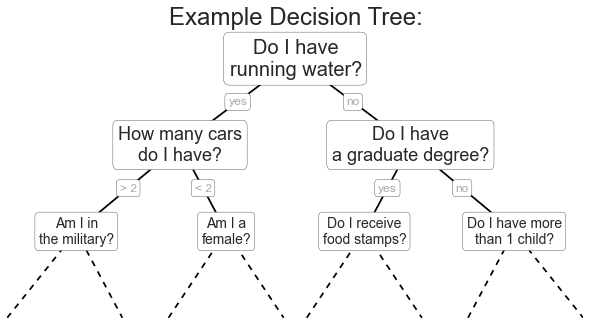

In [10]:
%matplotlib inline
import fig_Jake
import matplotlib.pyplot as plt

fig_Jake.plot_example_decision_tree()

### Decision trees: what's under the hood?

We build a *Boolean function* that successively partitions the data into 'yes healthcare' and 'no healthcare.' 

######Decision trees have *interior nodes* and *leaves*:
- Interior nodes correspond to a particular variable, and with discrete or categorical data, the branching of interior nodes is obvious ('Are you in the military?', 'Do you have a dog?', etc.). Splitting of interior nodes is less obvious for continous features, because you need to chose where to partition ('What is your income?', etc.).
- Leaves correspond to a decision. For example, perhaps everyone in the training data that has more than 3 cars, makes \$70000 per year, and is over age 60 has healthcare coverage. Then this can be modeled with a 3-level path, dead-ending at a leaf of 'yes healthcare.'

######Drawbacks/caveats:
- We could potentially build a decision tree with $2^{n}$ leaves, where every datapoint leads to its own dead-end!
- Tendancy to overfit training data if the number of features used to build the model is too high
